In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

# Part 1

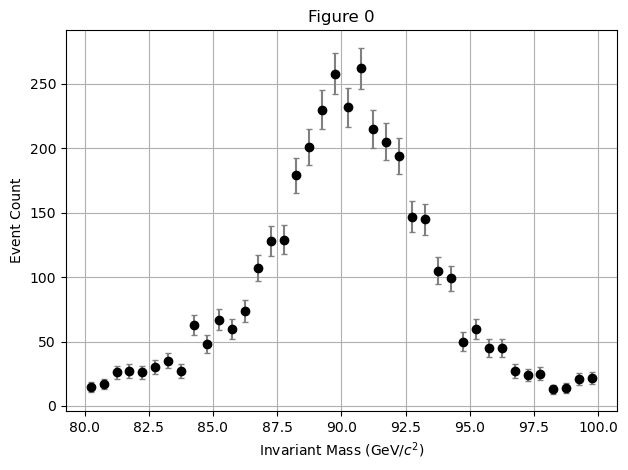

In [15]:
df = pd.read_csv('/Users/vaibh/Downloads/atlas_z_to_ll.csv', header=None)
df = df.apply(pd.to_numeric, errors='coerce')  
df = df.dropna()  
df.columns = ['pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'E1', 'E2']

px1 = df['pt1'] * np.cos(df['phi1'])
py1 = df['pt1'] * np.sin(df['phi1'])
pz1 = df['pt1'] * np.sinh(df['eta1'])

px2 = df['pt2'] * np.cos(df['phi2'])
py2 = df['pt2'] * np.sin(df['phi2'])
pz2 = df['pt2'] * np.sinh(df['eta2'])

E_tot = df['E1'] + df['E2']
px_tot = px1 + px2
py_tot = py1 + py2
pz_tot = pz1 + pz2

invariant_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

bins = np.linspace(80, 100, 41)
counts, bin_edges = np.histogram(invariant_mass, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)

plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Data', color='black', ecolor='gray', capsize=2)
plt.xlabel('Invariant Mass (GeV/$c^2$)')
plt.ylabel('Event Count')
plt.title('Figure 0')
plt.grid(True)
plt.tight_layout()
plt.show()

# Part 2

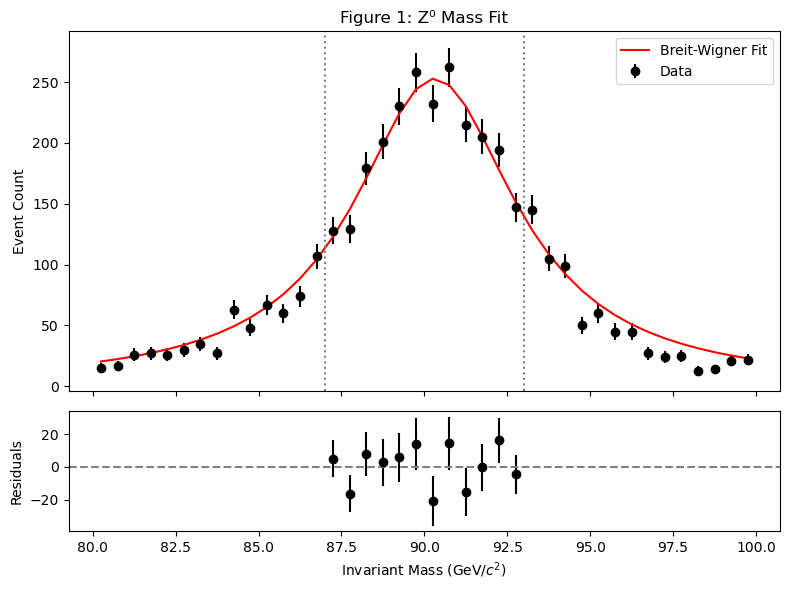

Fitted Z⁰ mass (m₀): 90.3 ± 0.1 GeV
Chi-square: 8.8
Degrees of freedom: 9
P-value: 0.459


In [20]:
def breit_wigner(m, m0, gamma, A):
    return A * (gamma/2)**2 / ((m - m0)**2 + (gamma/2)**2) / np.pi

mask = (bin_centers > 87) & (bin_centers < 93)
x_fit = bin_centers[mask]
y_fit = counts[mask]
y_err = errors[mask]

popt, pcov = curve_fit(breit_wigner, x_fit, y_fit, p0=[91.2, 2.5, 1000], sigma=y_err, absolute_sigma=True)
m0_fit, gamma_fit, amp_fit = popt
m0_err, gamma_err, amp_err = np.sqrt(np.diag(pcov))

x_plot = bin_centers
y_model = breit_wigner(x_plot, *popt)

residuals = counts - y_model
resid_masked = residuals[mask]
chi2_val = np.sum((resid_masked / y_err) ** 2)
ndof = len(y_fit) - len(popt)
pval = 1 - chi2.cdf(chi2_val, ndof)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

ax1.errorbar(bin_centers, counts, yerr=errors, fmt='o', color='black', label='Data')
ax1.plot(x_plot, y_model, color='red', label='Breit-Wigner Fit')
ax1.axvline(87, color='gray', linestyle='dotted')
ax1.axvline(93, color='gray', linestyle='dotted')
ax1.set_ylabel('Event Count')
ax1.set_title('Figure 1: Z⁰ Mass Fit')
ax1.legend()

ax2.errorbar(x_fit, resid_masked, yerr=y_err, fmt='o', color='black')
ax2.axhline(0, linestyle='dashed', color='gray')
ax2.set_xlabel('Invariant Mass (GeV/$c^2$)')
ax2.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

print(f"Fitted Z⁰ mass (m₀): {m0_fit:.1f} ± {m0_err:.1f} GeV")
print(f"Chi-square: {chi2_val:.1f}")
print(f"Degrees of freedom: {ndof}")
print(f"P-value: {pval:.3f}")

# Part 3

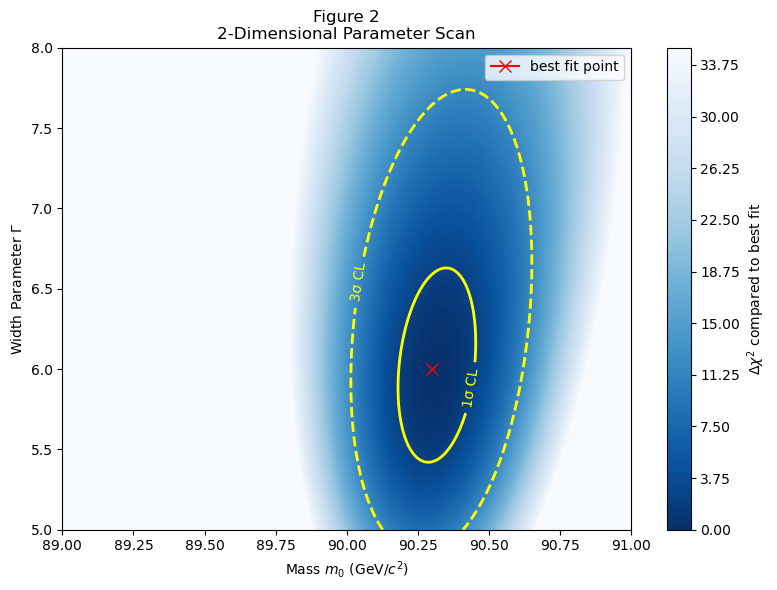

In [25]:
best_m0   = 90.3   
best_gam  = 6.0       
x_fit     = bin_centers[(bin_centers > 87) & (bin_centers < 93)]
y_fit     = counts[(bin_centers > 87) & (bin_centers < 93)]
y_err     = errors[(bin_centers > 87) & (bin_centers < 93)]

def bw_unit(m, m0, gam):
    return ((gam/2)**2 / ((m - m0)**2 + (gam/2)**2)) / np.pi

def chisq(m0, gam):
    f = bw_unit(x_fit, m0, gam)
    w    = 1 / y_err**2
    Ahat = np.sum(w * y_fit * f) / np.sum(w * f * f)
    chi2_val = np.sum(w * (y_fit - Ahat * f)**2)
    return chi2_val

m_grid = np.linspace(89.0, 91.0, 300)
g_grid = np.linspace(5.0,  8.0, 300)
M, G   = np.meshgrid(m_grid, g_grid)

chi2_map = np.vectorize(chisq)(M, G)
chi2_min = chi2_map.min()
dchi2    = chi2_map - chi2_min
dchi2_clipped = np.clip(dchi2, 0, 35)

lvl_1s = 2.30
lvl_3s = 11.83


plt.figure(figsize=(8,6))
cf = plt.contourf(M, G, dchi2_clipped, 150, cmap='Blues_r')
cbar = plt.colorbar(cf)
cbar.set_label(r'$\Delta\chi^2$ compared to best fit')

cs = plt.contour(M, G, dchi2, levels=[lvl_1s, lvl_3s],
                 colors='yellow', linestyles=['solid','dashed'], linewidths=2)
plt.clabel(cs, fmt={lvl_1s:'1σ CL', lvl_3s:'3σ CL'}, fontsize=10, inline=True)

plt.plot(best_m0, best_gam, marker='x', color='red', ms=8, label='best fit point')
plt.legend()

plt.title('Figure 2\n2‑Dimensional Parameter Scan')
plt.xlabel('Mass $m_0$ (GeV/$c^2$)')
plt.ylabel('Width Parameter $\\Gamma$')
plt.tight_layout()
plt.show()